# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas as pd # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF
# add seaborn for kernel density plot
import seaborn as sns

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

In [2]:
df = pd.read_csv("sealevel.csv")
df.head(10)

,Altimeter type,Merged file cycle nr,Year,Nr observations,Weighted nr observations,GMSL,GMSL std,GMSL smooth,GIA,GIA std,GIA smooth,GIA smooth cycle removed
0,0.0,11.0,1993.011526,466462.0,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0.0,12.0,1993.038692,460889.0,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
2,0.0,13.0,1993.065858,472123.0,342416.09,-40.17,92.29,-38.28,-40.16,92.29,-38.27,-37.60
3,0.0,14.0,1993.093025,421377.0,306050.59,-41.92,96.20,-38.56,-41.89,96.19,-38.54,-37.45
4,0.0,15.0,1993.120191,459548.0,331094.09,-36.89,94.64,-37.87,-36.85,94.63,-37.83,-36.44
5,0.0,16.0,1993.147357,416480.0,300344.81,-35.69,93.22,-36.96,-35.65,93.21,-36.93,-35.31
6,0.0,17.0,1993.174523,467980.0,337061.91,-36.09,91.67,-36.14,-36.05,91.67,-36.09,-34.28
7,0.0,18.0,1993.201689,466075.0,335414.41,-34.70,91.95,-35.53,-34.65,91.94,-35.48,-33.50
8,0.0,19.0,1993.228855,461207.0,331521.09,-34.04,91.70,-35.18,-33.98,91.68,-35.12,-32.94
9,999.0,20.0,1993.256021,467274.0,340098.59,-37.95,101.31,-35.09,-37.88,101.29,-35.02,-32.60


In [3]:
df.shape

(997, 12)

There are 12 features and 997 observations in this dataset

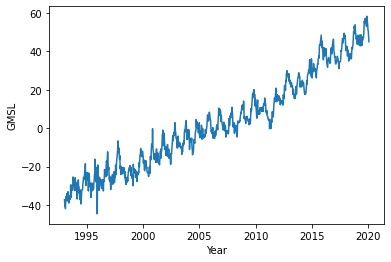

In [4]:
plt.plot(df['Year'], df['GMSL'])
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.show()

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** AR models assume that the time series data has a Gaussian noise term. By removing the trend, we look only at the residuals which is equivalent to the maximum likelihood estimation in the case of linear regression.

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t $ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t = $ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t $.

**A3:**

In [5]:
linreg = lm.LinearRegression()
X = df['Year'].array.reshape(-1, 1)
y = df['GMSL'].array.reshape(-1, 1)
linreg = linreg.fit(X, y)
pred = linreg.predict(X)

res = (y-pred).reshape(997,) # have to reshape in order to avoid pd.DataFrame() issues in next question !!!!!!

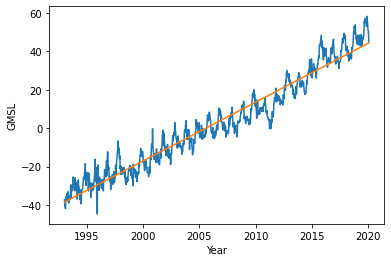

In [6]:
plt.plot(df['Year'], df['GMSL'])
plt.plot(df['Year'], pred)
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.show()

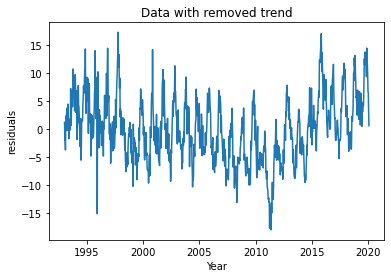

In [7]:
plt.plot(df['Year'], res)
plt.xlabel('Year')
plt.ylabel('residuals')
plt.title('Data with removed trend')
plt.show()

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

In [8]:
# collect all data into one data frame for convenience
data = pd.DataFrame(data = {'Year' : df['Year'], 
                            'GMSL' : res})

# train/valid split on 700th value
train, valid = data.iloc[0:699, ], data.iloc[700:, ]

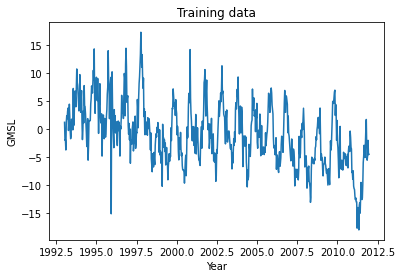

In [9]:
# Plot Train
Xtrain, ytrain = train['Year'], train['GMSL']
plt.plot(Xtrain, ytrain)
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Training data')
plt.show()

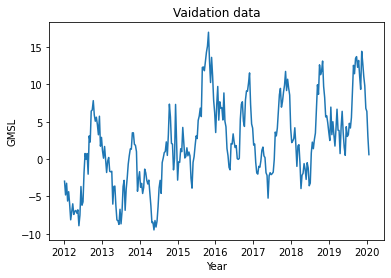

In [10]:
# Plot Validation
Xvalid, yvalid = valid['Year'], valid['GMSL']
plt.plot(Xvalid, yvalid)
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.title('Vaidation data')
plt.show()

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [11]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y)
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p)) 
    for j in range(p):
        Phi[:,j] = y.loc[j: n-p+j-1] # needed the -1 else I was off by 1 because we go from t=p+1 to n so we have to remove it
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{t+p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)    

    return regr.coef_

In [12]:
theta_train = fit_ar(ytrain, 10)
print(f"Coefficients: {theta_train}")

Coefficients: [ 0.02206704 -0.11163581  0.07633489 -0.09452033 -0.0596791  -0.02250214
  0.1739748   0.15154552  0.10729441  0.62153965]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [13]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    y_pred = np.zeros(n)
    
    for i in range(n):
        if i < p:
            y_pred[i] = y_target[i]
        else:
            y_pred[i] = np.matmul(np.transpose(theta), y_target[i-p:i])
    
    m = n-p
    mse = np.sum((y_target - y_pred)**2)/m
    residuals = y_target - y_pred
        
    return {"predictions": y_pred, "mse": mse, "residuals": residuals}

In [14]:
# predict for training an test
# training 
pred_train = predict_ar_1step(theta_train, np.array(ytrain))
# validation
pred_valid = predict_ar_1step(theta_train, np.array(yvalid)) #y_target needs to be an array. Indexing starts at 700


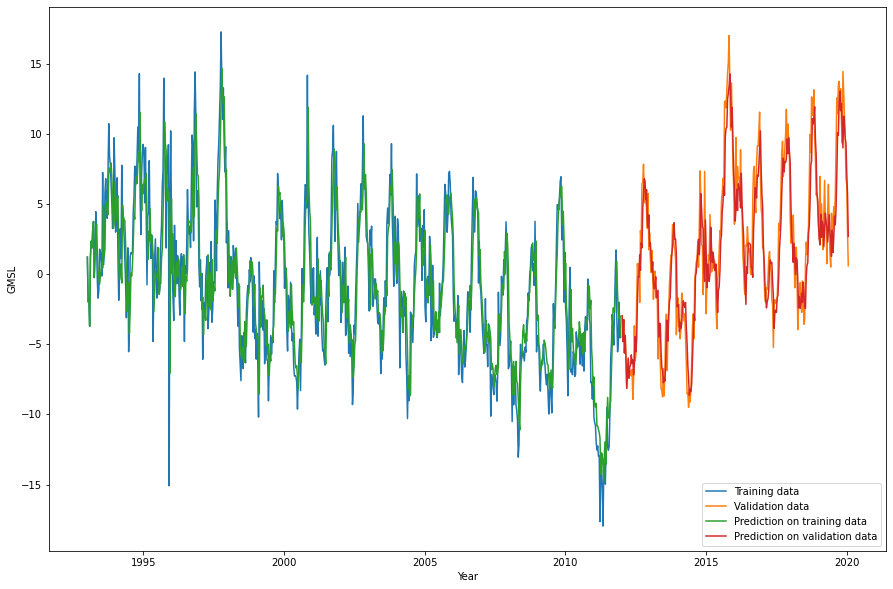

In [15]:
# Plot fitted data
plt.figure(figsize=(15,10))
plt.plot(Xtrain, ytrain, label= 'Training data')
plt.plot(Xvalid, yvalid, label= 'Validation data')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.plot(Xtrain, pred_train["predictions"], label = 'Prediction on training data') # data is shifted by theta_train
plt.plot(Xvalid, pred_valid["predictions"], label = 'Prediction on validation data')
plt.legend(loc='lower right')
plt.show()

/Users/yuki/opt/miniconda3/envs/tssl/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


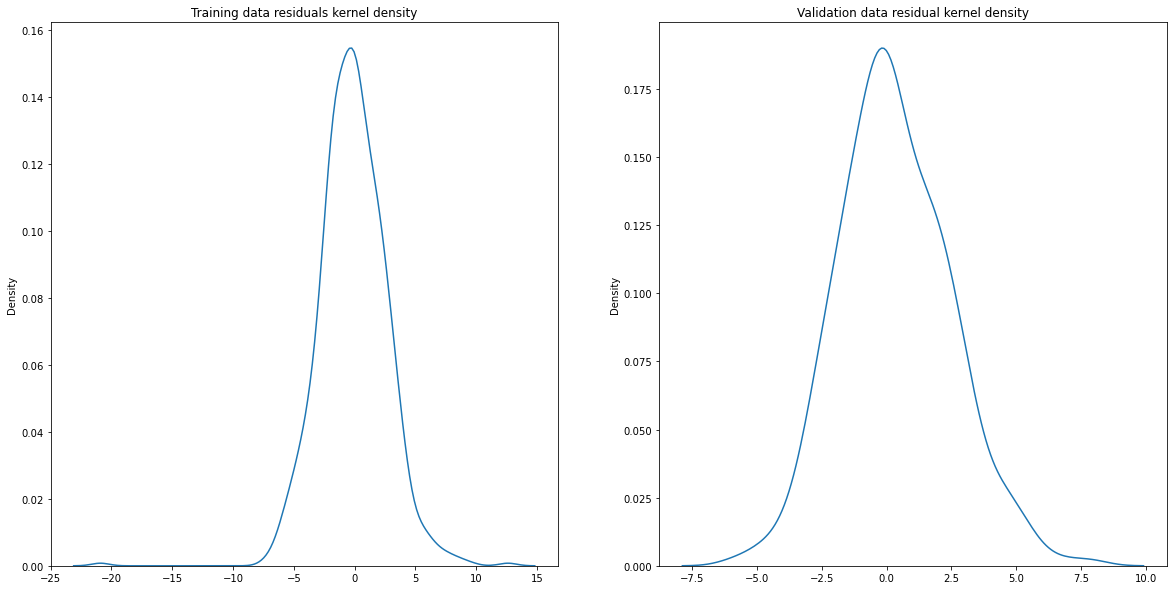

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot residuals for training and validation
sns.kdeplot(pred_train["residuals"], ax=ax[0]).set_title('Training data residuals kernel density')# plot residuals for validation
sns.kdeplot(pred_valid["residuals"], ax=ax[1]).set_title('Validation data residual kernel density')
fig.show()

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

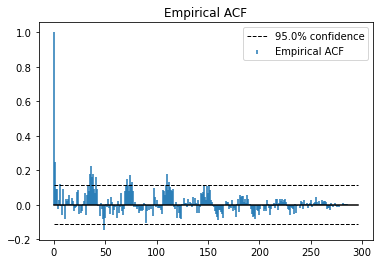

In [17]:
# help(acfplot)
acfplot(pred_valid["residuals"])

We have several values that lie beyond the 95% confidence bounds for the autocorrelation of a white noise sequence. We have reasons to suspect that this AR(10) model doesn't describe the behaviour of the residuals from the data as white noise. We should choose a different p value that better satisfies the condition of white noise.

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

In [18]:
mse_train = {}
mse_valid = {}

for i in range(2,151):
    theta_i = fit_ar(ytrain, i)
    
    mse_train[i] = predict_ar_1step(theta_i, np.array(ytrain))["mse"]
    mse_valid[i] = predict_ar_1step(theta_i, np.array(yvalid))["mse"]

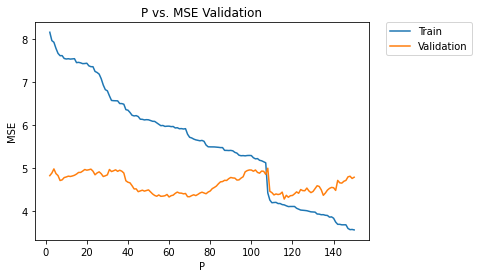

In [19]:
# P vs. MSE Valid
plt.plot(mse_train.keys(), mse_train.values(), label="Train")
plt.plot(mse_valid.keys(), mse_valid.values(), label="Validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('P')
plt.ylabel('MSE')
plt.title('P vs. MSE Validation')
plt.show()

It can be observed that the Validation MSE is rather stable moving between 5 and 4. On the other hand the Training MSE is monotonically decreasing starting around 8 and ending up at ~3.5.

In [20]:
p_opt = min(mse_valid, key=mse_valid.get)
print(f"Optimal p = {p_opt}")

Optimal p = 116


We are chosing p = 116 as our optimal p value since it show the smallest MSE value. We could have also chosen p = 60. Even though it only shows to be the third smallest MSE value it is a significantly smaller order value which is less prone to overfitting.

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

In [21]:
theta_opt = fit_ar(ytrain, p_opt)
    
pred_train_opt = predict_ar_1step(theta_opt, np.array(ytrain))
pred_valid_opt = predict_ar_1step(theta_opt, np.array(yvalid))

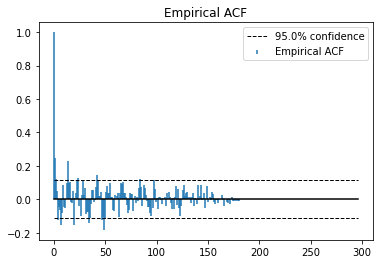

In [22]:
acfplot(pred_valid_opt["residuals"])

**A9**: From the ACF plot it can be seen that in contrast to the initial AR(10) model most of the residuals lie inside the 95% confidence interval. Thus, the model performance of our AR(116) model is superior to the AR(10) model.

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], & t&=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [23]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    
    phi = np.array(np.flip(y[-p:].copy())) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    for i in range(m):
        sim_val = np.matmul(phi, np.flip(theta))
        y_sim[i] = sim_val
        phi = np.insert(phi[0:-1], 0, sim_val)
    
    return y_sim
    

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

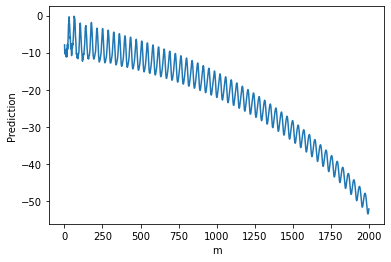

In [24]:
theta = fit_ar(ytrain, p_opt)
sim_results = simulate_ar(ytrain ,theta, 2000)
plt.plot(range(1,2001), sim_results)
plt.xlabel("m")
plt.ylabel("Prediction")
plt.show()

Using the p value with the lowest MSE on the validation set we can't observe our predictions converging to a constant value of zero. If on the other hand we chose a smaller p value such as the third lowest MSE given by p=60 (second lowest MSE at 118 shows same issues as our optimal p) we can finally observe the predictions converging to 0 after a certain period of time. 

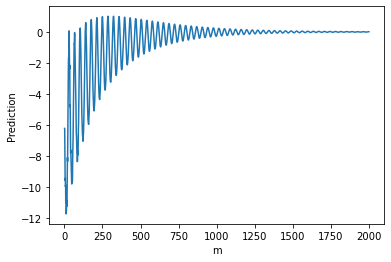

In [25]:
# Using p = 60

theta = fit_ar(ytrain, 60)
sim_results = simulate_ar(ytrain ,theta, 2000)
plt.plot(range(1,2001), sim_results)
plt.xlabel("m")
plt.ylabel("Prediction")
plt.show()

Observing that predictions converge to zero after a certain number of **m** is expected, since prediction uncertainty rises the further ahead we try to forecast. Thus, those predictions are almost only influenced by our noise terms with a mean of 0. 

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [26]:
def predict_nar(train, validation, p, layer=1, neurons=10, act_fun="relu", solver="adam"):
    # Number of training data points
    n = len(train)
    
    # Construct the regression matrix
    Phi = np.zeros((n-p, p)) 
    for j in range(p):
        Phi[:,j] = train.loc[j: n-p+j-1] # needed the -1 else I was off by 1 because we go from t=p+1 to n so we have to remove it
    
    # Drop the first p values from the target vector y
    yy = train[p:]  # yy = (y_{t+p+1}, ..., y_n)
    
    mlp_reg = MLPRegressor(hidden_layer_sizes=(neurons,layer), activation=act_fun, solver=solver)
    fit = mlp_reg.fit(Phi, yy)
    
    # Train 
    train_predictions = fit.predict(Phi)
    train_residuals = yy - train_predictions
    
    # Validation
    n_valid = len(validation)
    Phi_valid = np.zeros((n_valid-p, p)) 
    for j in range(p):
        Phi_valid[:,j] = validation.loc[n+j+1: n+n_valid-p+j]
        
    valid_predictions = fit.predict(Phi_valid)
    valid_residuals = validation[p:] - valid_predictions
        
    return {
            "train_predictions": train_predictions,
            "train_residuals": train_residuals,
            "valid_predictions": valid_predictions,
            "valid_residuals": valid_residuals
           }

results_nar = predict_nar(ytrain, yvalid, p_opt)

/Users/yuki/opt/miniconda3/envs/tssl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


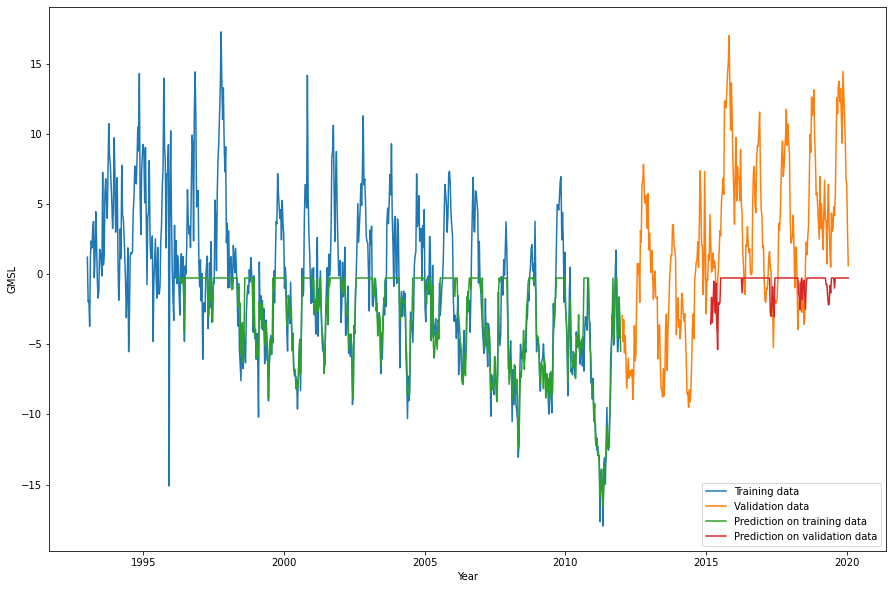

In [27]:
# Plot fitted data
plt.figure(figsize=(15,10))
plt.plot(Xtrain, ytrain, label= 'Training data')
plt.plot(Xvalid, yvalid, label= 'Validation data')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.plot(Xtrain[p_opt:], results_nar["train_predictions"], label = 'Prediction on training data')
plt.plot(Xvalid[p_opt:], results_nar["valid_predictions"], label = 'Prediction on validation data')
plt.legend(loc='lower right')
plt.show()

/Users/yuki/opt/miniconda3/envs/tssl/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


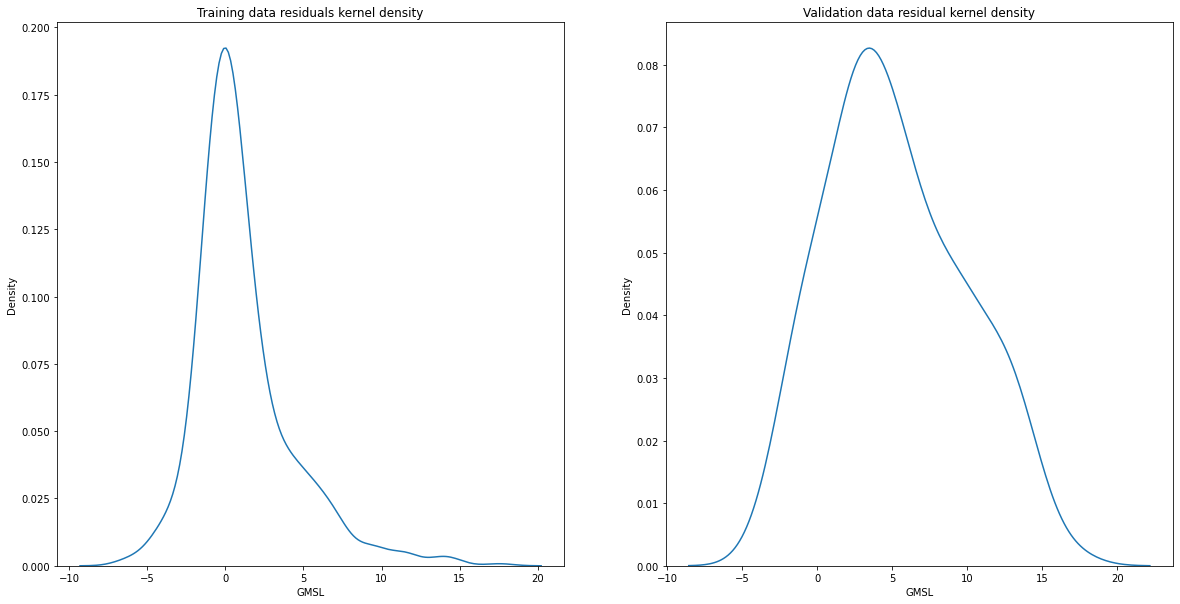

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot residuals for training and validation
sns.kdeplot(results_nar["train_residuals"], ax=ax[0]).set_title('Training data residuals kernel density')
sns.kdeplot(results_nar["valid_residuals"], ax=ax[1]).set_title('Validation data residual kernel density')

fig.show()

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

In [29]:
results_nar_opt = predict_nar(ytrain, yvalid, p_opt, layer=2, neurons=32, act_fun="tanh", solver="lbfgs")

/Users/yuki/opt/miniconda3/envs/tssl/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


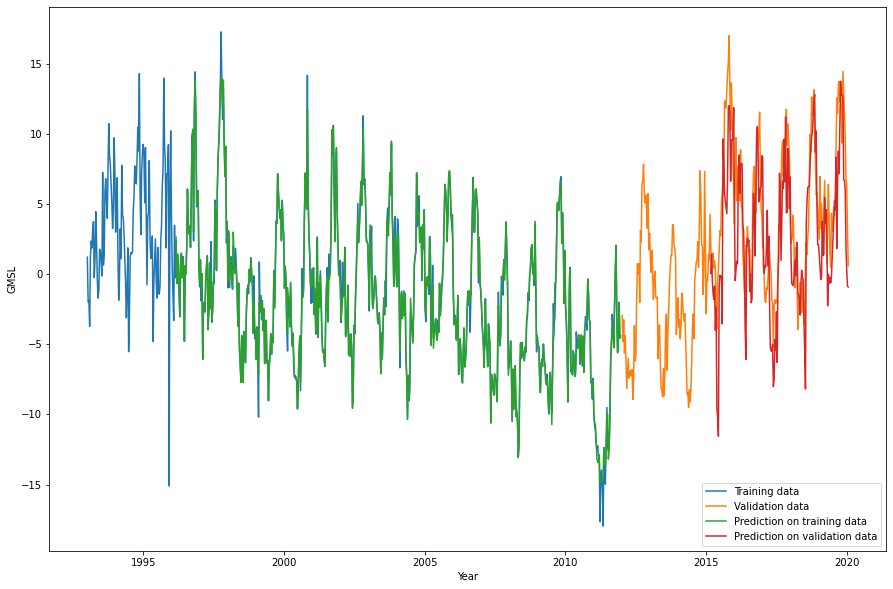

In [30]:
# Plot fitted data
plt.figure(figsize=(15,10))
plt.plot(Xtrain, ytrain, label= 'Training data')
plt.plot(Xvalid, yvalid, label= 'Validation data')
plt.xlabel('Year')
plt.ylabel('GMSL')
plt.plot(Xtrain[p_opt:], results_nar_opt["train_predictions"], label = 'Prediction on training data')
plt.plot(Xvalid[p_opt:], results_nar_opt["valid_predictions"], label = 'Prediction on validation data')
plt.legend(loc='lower right')
plt.show()

/Users/yuki/opt/miniconda3/envs/tssl/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


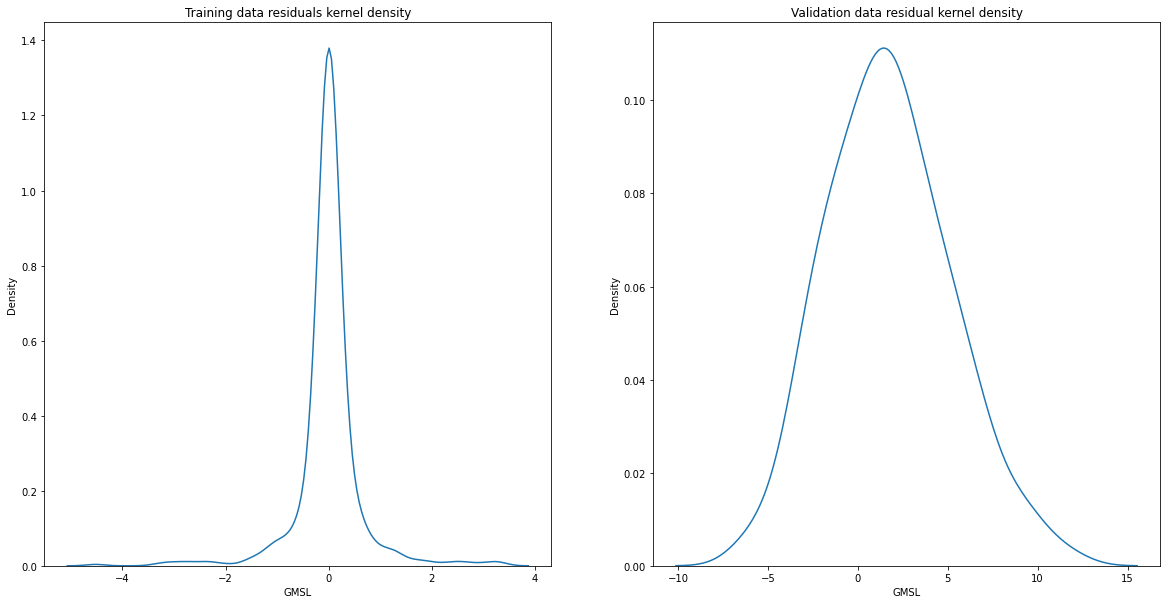

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot residuals for training and validation
sns.kdeplot(results_nar_opt["train_residuals"], ax=ax[0]).set_title('Training data residuals kernel density')
sns.kdeplot(results_nar_opt["valid_residuals"], ax=ax[1]).set_title('Validation data residual kernel density')

fig.show()

When we use the *ReLU* activation function with one layer only positive values are activated since *ReLU* returns zero for negative inputs. We can circumvent this issue by using a different activation function such as the *tanh* that has a range of -1 to 1. We also choose to increase the network complexity by adding another layer, increasing the number of neurons and changing the optimizer function until we reached the results shown above.

Although visually our predictions on the training and validation data look satisfying, the kernel densities of the residuals are not looking perfectly gaussian. We observe fat tails in the training data residuals indicating kernel mass that is not normally distributed. For the validation data we can observe that the residuals are not centered on zero and the distribution is asymmetric.

This leads us to believe that our MLPRegressor yields worse results than our linear solutions. Thus, a simple linear approach might be the preferable option over a more complex one. We would need to create a very complicated network to reach results similar to the initial linear model.